<a href="https://colab.research.google.com/github/Lor3nzoVis3/DeepLearning_ProjectLV_GB/blob/master/TransferLearningV3_faceOrientation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
"""
@authors: LorenzoVisentini and Gianmarco Bolcato
"""

modelName = "InceptionV3"

#import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#keras
import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, GlobalMaxPooling2D, BatchNormalization
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
#inception v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.utils import plot_model

import random
random.seed(42)

In [9]:
# link with Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# Images parameters
img_target_size = (229, 229)
shape = (229, 229, 3)

# Jupyter notebook paths
train_dir = './orient/train'
val_dir = './orient/val' 
test_dir = './orient/test' 

# Google Colab paths
# train_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/train'
# val_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/val' 
# test_dir = '/content/drive/My Drive/Deep Learning Project - Image Classification/orient/test' 

In [11]:
n_classes = 3

# Hyperparameters
batch_size = 32
epochs = 10
drop_rate = 0.5
lr = 0.002

# variable to check if it's applied the batchNormalization patch
patch = True

# file_model = '/content/drive/My Drive/Deep Learning Project - Image Classification/Models/'+ modelName + 'OR' + '_Bs' + str(batch_size) + '_Ep' + str(epochs) + '_Dr' + str(drop_rate) + '_Lr' + str(lr)
file_model = modelName + 'OR' + '_Bs' + str(batch_size) + '_Ep' + str(epochs) + '_Dr' + str(drop_rate) + '_Lr' + str(lr)
if patch == True:
    file_model = file_model + '_patched'

In [12]:
#from https://edebrouwer.github.io/deeplearning/carvision/transfer/neural/networks/learning/2017/08/05/TransferLearning.html

#Transfer learning on InceptionV3 model
#use all the layers except for the last fully connected layer (because its 
#specific to the ImageNet competition)
#we will retrain layers with new inputs
pre_trained_model = InceptionV3(input_shape = shape,
                               include_top = False, #exclude last flatten layer
                               weights = 'imagenet' #weights from imageNet
                               ) 

# pre_trained_model.summary() #check V3 structure

In [13]:
#transfer learning phase
x = pre_trained_model.output

x = GlobalMaxPooling2D()(x)
x = Dropout(drop_rate)(x)

x = Dense(512, activation= 'relu')(x) #add fully connected layer
x = BatchNormalization()(x)

x = Dense(n_classes, activation= 'softmax')(x)
model = Model(inputs = pre_trained_model.input, outputs = x)

#freeze the model excepted added layers
# for layer in pre_trained_model.layers:
#     layer.trainable = False

#because of BN normalization problem: https://github.com/keras-team/keras/issues/9214
for layer in pre_trained_model.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
            layer.trainable = True
            K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
            K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False

opt = optimizers.Adam(learning_rate=lr)
model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',  #because we have 3 possible outputs
              metrics = ['accuracy'])

In [14]:
# plot model tree
tree_path = './ModelTrees/'
if os.path.exists(tree_path) == False:
    os.makedirs(tree_path)
else: 
    print('Folder Plots already exists')
plot_model(model, to_file=f"{tree_path}/{file_model}.png", show_layer_names=True, show_shapes=True)

Folder Plots already exists


In [15]:
# preprocessing
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

train_gen = ImageDataGenerator(width_shift_range=[0,0.2],
                            height_shift_range=[0,0.2],
                            zoom_range=[0.8,1.0],
                            fill_mode="nearest")
# train_gen = ImageDataGenerator()

# Set aug variable to save if the model used data augmentation or not
aug = True
if aug == True:
    modelName = modelName+'Aug'

test_gen = ImageDataGenerator()    

train_generator = test_gen.flow_from_directory(directory=train_dir,
                                                    target_size=img_target_size,
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

val_generator = test_gen.flow_from_directory(directory=val_dir,
                                                    target_size=img_target_size,
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=42
                                                    )

test_generator = test_gen.flow_from_directory(directory = test_dir,
                                                    target_size = img_target_size,
                                                    color_mode="rgb",
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    shuffle=True,
                                                    seed=42
                                                )
# DONT PUT SHUFFLE = FALSE

Found 7135 images belonging to 3 classes.
Found 1529 images belonging to 3 classes.
Found 1530 images belonging to 3 classes.


In [16]:
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = train_generator.n//batch_size,
                             epochs = epochs,
                             validation_data = val_generator,
                             validation_steps=val_generator.n//batch_size
                             )

Epoch 1/10
222/222 [==============================] - 81s 366ms/step - loss: 1.0493 - accuracy: 0.5831 - val_loss: 0.8013 - val_accuracy: 0.6257
Epoch 2/10
222/222 [==============================] - 64s 290ms/step - loss: 0.7721 - accuracy: 0.6752 - val_loss: 0.3978 - val_accuracy: 0.6961
Epoch 3/10
222/222 [==============================] - 63s 282ms/step - loss: 0.6465 - accuracy: 0.7425 - val_loss: 0.4533 - val_accuracy: 0.7876
Epoch 4/10
222/222 [==============================] - 63s 283ms/step - loss: 0.5123 - accuracy: 0.7992 - val_loss: 0.4447 - val_accuracy: 0.8236
Epoch 5/10
222/222 [==============================] - 63s 283ms/step - loss: 0.4412 - accuracy: 0.8329 - val_loss: 0.4671 - val_accuracy: 0.8243
Epoch 6/10
222/222 [==============================] - 63s 283ms/step - loss: 0.3951 - accuracy: 0.8501 - val_loss: 0.5718 - val_accuracy: 0.8156
Epoch 7/10
222/222 [==============================] - 63s 283ms/step - loss: 0.3637 - accuracy: 0.8643 - val_loss: 0.7537 - val_ac

In [17]:
# consider highlight the different values of hyperparameters used
# OR orient o SL source light, Bs batch size, Ep epochs, Dr drop rate, Lr learning rate
# CHECK ALWAYS BOOLEAN PATCH VALUES (on top)

# create models folder if doesn't exist
path_models = './Models'
if os.path.exists(path_models) == False:
    os.makedirs(path_models)
else: 
    print('Folder Models already exists')
    
# save model and history
model.save(path_models + file_model + '.h5')
print(file_model)

#save history
# create models folder if doesn't exist
path_history = './History/'
if os.path.exists(path_history) == False:
    os.makedirs(path_history)
else: 
    print('Folder History already exists')
file_hist = path_history + file_model + '.csv'
df_history = pd.DataFrame(history.history)
with open(file_hist, 'w') as file:
    df_history.to_csv(file)
print(file_hist)

Folder Models already exists
InceptionV3OR_Bs32_Ep10_Dr0.5_Lr0.002_patched
Folder History already exists
./History/InceptionV3OR_Bs32_Ep10_Dr0.5_Lr0.002_patched.csv


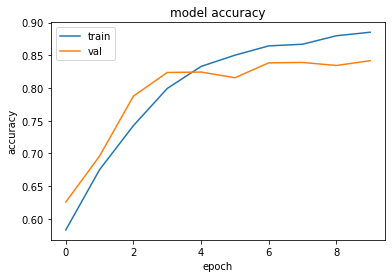

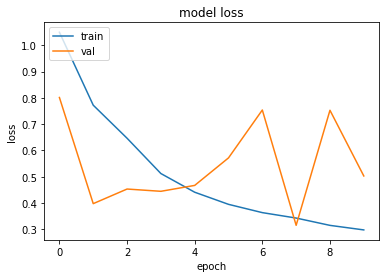

<Figure size 432x288 with 0 Axes>

In [18]:
# Plot path
plot_path = './Plots/'
if os.path.exists(plot_path) == False:
    os.makedirs(plot_path)
else: 
    print('Folder Plots already exists')
plot_file = plot_path + file_model + '.png'

#plot results
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.savefig(plot_file)

In [19]:
#evaluation
# https://stackoverflow.com/questions/40564936/keras-what-is-the-difference-between-model-evaluate-generator-and-model-predict
steps = test_generator.n // test_generator.batch_size
accuracy_ontest = model.evaluate_generator(test_generator, steps)
print(accuracy_ontest)

[0.33040738105773926, 0.8603723645210266]
